In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [3]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, )#, dtype='Int64')


In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1219999, 23)

In [6]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,10010000001,2,81,8,91,9,6,21,21,1,71,41,7,4,12,4,20,2,2,1,51,5,1.0
1,20010000006,1,75,7,43,4,6,6,13,2,71,64,7,6,12,9,4,12,4,13,12,1,1.0
2,30010000011,1,76,7,43,4,6,6,16,3,54,81,5,8,7,12,6,6,4,18,36,3,2.0
3,40010000013,3,75,7,43,4,4,6,13,1,71,36,7,3,12,11,11,19,4,6,21,2,1.0
4,50010000015,2,33,3,44,4,6,7,12,1,71,42,7,4,12,5,14,3,3,1,14,1,2.0


In [7]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    #model.fit(X_train, y_train)
    y_pred_test = (model.predict(X_test) > 0.5).astype("int64")
    y_pred_train = (model.predict(X_train) > 0.5 ).astype("int64")

    print("test set : ")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test)) 
    print("train set : ")
    print(confusion_matrix(y_train, y_pred_train )) # ajouter 
    print(classification_report(y_train, y_pred_train ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def quarantiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne IFI+ :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)
    
    # création du tableau final en éliminant la colonne 2
    tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)



In [8]:

from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score

In [ ]:
#######################################################################################################
#                                          PREMIERS TESTS
#######################################################################################################

In [ ]:
##########################################
# AVEC TOUTES LES VARIABLES ET ENCODAGE DUMMIES
##########################################

# test predict individus sans classe
data = data_orig.copy()

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
"""
# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks()
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))


# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
"""



'\n# dimension du train set\nprint("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))\n\n# diminution des données\nt2 = TomekLinks()\nX_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )\nprint("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))\n\n# augmentation des données\ntl = SMOTE()\nX_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )\nprint("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))\n\n\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [ ]:
# Résultat du traitement sur le train set (under-sampling et over-sampling)
abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
abc_np = abc_test.to_numpy(dtype="Int64")

X_resampled = abc_np[:,:-1]
y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [ ]:
#model_MLP = MLP(random_state = 0)
#model_MLP.fit(train_X_s, train_Y_s)

final_model_MLP = MLPClassifier(random_state=0)
evaluation(final_model_MLP , X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


test set : 
[[  892  3787]
 [ 1675 19069]]
              precision    recall  f1-score   support

           1       0.35      0.19      0.25      4679
           2       0.83      0.92      0.87     20744

    accuracy                           0.79     25423
   macro avg       0.59      0.55      0.56     25423
weighted avg       0.74      0.79      0.76     25423

train set : 
[[67889 11442]
 [ 2635 76696]]
              precision    recall  f1-score   support

           1       0.96      0.86      0.91     79331
           2       0.87      0.97      0.92     79331

    accuracy                           0.91    158662
   macro avg       0.92      0.91      0.91    158662
weighted avg       0.92      0.91      0.91    158662

GRAPHIQUE NON DEMANDE


In [ ]:
model_MLP = MLPClassifier(random_state =0 )
param = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid_MLP = GridSearchCV(model_MLP, param, cv = 4, scoring = "recall", n_jobs=2)
resultat_grid_MLP = grid_MLP.fit(X_resampled, y_resampled)
resultat_grid_MLP.best_params_


In [ ]:
final_model_MLP = MLPClassifier(activation="relu", alpha=0.0001, hidden_layer_sizes=(50,100,50), learning_rate="constant",solver="sgd",  random_state =0 )
evaluation(final_model_MLP , X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)

In [ ]:
final_model_MLP = MLPClassifier(activation="relu", alpha=0.0001, hidden_layer_sizes=(50,100,50), learning_rate="constant",solver="adam",  random_state =0 )
evaluation(final_model_MLP , X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)

In [ ]:
final_model_MLP = MLPClassifier(max_iter=100, activation="relu", alpha=0.0001, hidden_layer_sizes=(50,100,50), learning_rate="constant",solver="adam",  random_state =0 )
evaluation(final_model_MLP , X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)

In [ ]:
#######################################################################################################
#                                         FIN PREMIERS TESTS
#######################################################################################################

In [ ]:
###########################################################################################################
#                                                   KERAS 
###########################################################################################################


In [ ]:
##########################################
# SANS LES VARIABLES CORR  ET ENCODAGE DUMMIES
#########################################

In [9]:
# test predict individus sans classe
data = data_orig.copy()

# on élimine les variables dons
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F",
                "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)

# encodage Onehot sur toutes les données (on évite ainsi les erreurs futures)
nb_var = data.shape[1] - 1
data_1_22 = pd.get_dummies(data.iloc[:,1:(data.shape[1]-1)], columns=data.columns[1:(data.shape[1]-1)] )
data_var_qualitatives_temp =  pd.concat([data["IDENT"], data_1_22, data["Top_mon"]], axis=1)
data = data_var_qualitatives_temp
#encodage = OneHotEncoder()
#encodage.fit(data_processing(data.iloc[:,1:nb_var]))

# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

# base de données avec des variables corrélées et avec encodage OneHot
data =data_sans_nan

nb_var = data.shape[1] - 1
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])
train_Y_s[train_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])
test_Y_s[test_Y_s==2]=0
train_Y_s[train_Y_s==1]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [21]:

from keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.utils import class_weight 
# np.random.seed(0)






# Create function returning a compiled network

def create_network(number_of_features):
    # numbers of features
    number_of_features = number_of_features  #train_X_s.shape[1]

    # start neural network
    network = models.Sequential()

    # add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=50, activation="relu", input_shape = (number_of_features, ) ))

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=100, activation = "relu" ) )

    # add fully connected layer with a ReLu activation function
    network.add(layers.Dense(units=50, activation = "relu" ) )    

    # add fully connected layer with a ReLu activation function
    #network.add(layers.Dense(units=10, activation = "relu" ) )    

    # add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation = "sigmoid" ) )

    # compile neural network
    network.compile(loss="binary_crossentropy", optimizer ="adam", metrics = ["accuracy"] )


    return network


In [11]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_Y_s ),train_Y_s)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6132304166917928, 1: 2.7078873089417903}

Text(0, 0.5, 'Accuracy Score')

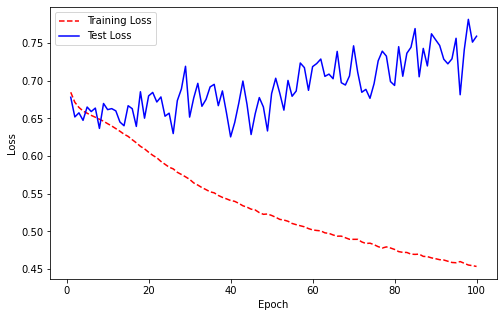

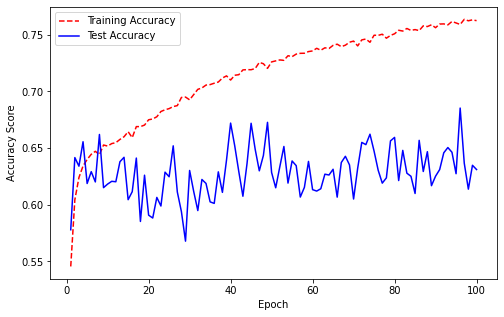

In [22]:
# 
# train neural network
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=100, verbose=0, batch_size=6780,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))

# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# visualize loss history
plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_loss, "r--" )
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# get training and test accuracy histories

training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")


In [23]:
network = create_network( number_of_features=train_X_s.shape[1])
history= network.fit(train_X_s, train_Y_s, epochs=8, verbose=0, batch_size=6780,class_weight=class_weights , validation_data=(test_X_s, test_Y_s))


In [24]:
evaluation(network, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall", plot=False)

test set : 
[[13070  7674]
 [ 2131  2548]]
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     20744
           1       0.25      0.54      0.34      4679

    accuracy                           0.61     25423
   macro avg       0.55      0.59      0.53     25423
weighted avg       0.75      0.61      0.66     25423

train set : 
[[53691 29224]
 [ 7759 11018]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74     82915
           1       0.27      0.59      0.37     18777

    accuracy                           0.64    101692
   macro avg       0.57      0.62      0.56    101692
weighted avg       0.76      0.64      0.68    101692

GRAPHIQUE NON DEMANDE


In [33]:
#k-fold cross-validation neural networks ( FOR SMALLER DATA )

# wrap Keras model so it can be used by scikit-learn 
neural_network = KerasClassifier(build_fn =lambda:create_network(number_of_features=train_X_s.shape[1]), epochs=8, batch_size=6780, verbose=0)

# evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, train_X_s, train_Y_s, cv = 4, n_jobs=2, scoring="accuracy")



array([0.81414467, 0.81807812, 0.81367266, 0.81552138])

In [ ]:
101692-6780*14

6772

In [ ]:
####################################################################################################
#
#                                       UNDER-SAMPLING  ET OVER-SAMPLING
#
####################################################################################################

In [25]:
# Résultat du traitement sur le train set (under-sampling et over-sampling)
abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
abc_np = abc_test.to_numpy(dtype="Int64")

X_resampled = abc_np[:,:-1]
y_resampled = abc_np[:, abc_np.shape[1] -1 ]

In [26]:
X_resampled.shape, y_resampled.shape

((160026, 269), (160026,))

Text(0, 0.5, 'Accuracy Score')

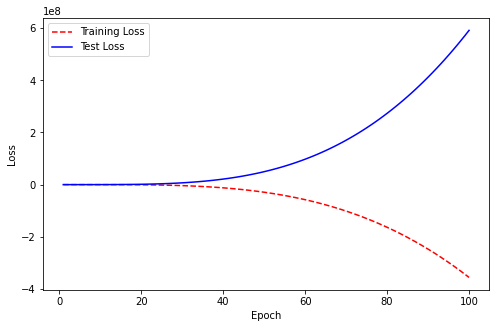

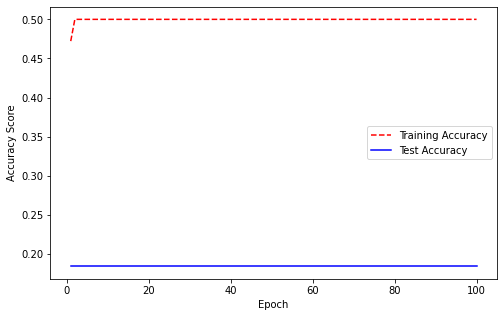

In [27]:
# 
# train neural network
network = create_network( number_of_features = X_resampled.shape[1])
history= network.fit( X_resampled, y_resampled, epochs=100, verbose=0, batch_size=6780, validation_data=(test_X_s, test_Y_s))

# get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# visualize loss history
plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_loss, "r--" )
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

# get training and test accuracy histories

training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8,5))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")


In [28]:
evaluation(network, X_resampled, y_resampled, test_X_s, test_Y_s, scoring="recall", plot=False)

test set : 
[[    0 20744]
 [    0  4679]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20744
           1       0.18      1.00      0.31      4679

    accuracy                           0.18     25423
   macro avg       0.09      0.50      0.16     25423
weighted avg       0.03      0.18      0.06     25423

train set : 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[80013     0]
 [80013     0]]
              precision    recall  f1-score   support

           1       0.50      1.00      0.67     80013
           2       0.00      0.00      0.00     80013

    accuracy                           0.50    160026
   macro avg       0.25      0.50      0.33    160026
weighted avg       0.25      0.50      0.33    160026

GRAPHIQUE NON DEMANDE


array([2, 1, 2, ..., 1, 1, 1])

In [29]:
#k-fold cross-validation neural networks ( FOR SMALLER DATA )

# wrap Keras model so it can be used by scikit-learn 
neural_network = KerasClassifier(build_fn =lambda:create_network(number_of_features=X_resampled.shape[1]), epochs=100, batch_size=6780, verbose=0)

# evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, X_resampled, y_resampled, cv = 4, n_jobs=2)



array([0.77213985, 0.75409305, 0.89359099, 0.98797679])

In [ ]:
# wrap keras model s
neural_network = KerasClassifier(build_fn = create_network, verbose =0)

# create hyperparameters 
hyperparameters = {optimizer = ["rmsprop", "adam"] , epochs = [5, 10], batch_size = [5, 10, 100]   }

grid = GridSearchCV(estimator = neural_network, param_grid=hyperparameters)

result = grid.fit( , )

result.best_params_

dtype('int64')